In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy

from gensim.models.phrases import npmi_scorer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.phrases import Phrases

from sklearn.model_selection import train_test_split
from statsmodels.stats import inter_rater as irr
from itertools import combinations

pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 999)

dataset_folder = 'datasets'

In [2]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plty

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Keller\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Keller\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
FLEISS_KAPPA_INTERVALS = {
    'poor': lambda x: x < 0,
    'slight': lambda x: (x > 0) & (x <= 0.2),
    'fair': lambda x: (x > 0.2) & (x <= 0.4),
    'moderate': lambda x: (x > 0.4) & (x <= 0.6),
    'substantial': lambda x: (x > 0.6) & (x <= 0.8),
    'almost perfect': lambda x: x > 0.8
}

def get_fleiss_kappa(dataframe, annotator_col, post_col, label_col):
    data_arr = pd.pivot(dataframe, columns=annotator_col, index=post_col, values=label_col).to_numpy()
    return irr.fleiss_kappa(irr.aggregate_raters(data_arr)[0], method='fleiss')

def get_fleiss_kappa_interpretation(kappa_value):
    for key, value in FLEISS_KAPPA_INTERVALS.items():
        if FLEISS_KAPPA_INTERVALS[key](kappa_value):
            return key

In [5]:
# Source: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

### Phase 1 (Common understanding)

In [6]:
# Load annotated posts of phase 1
annotations_ph1  = pd.read_csv('datasets/misogynistic_hatespeech_phase1.csv')

In [7]:
# Total number of annotations
annotations_ph1['phase'].value_counts()

1    11
Name: phase, dtype: int64

In [8]:
# Show attributes
annotations_ph1.count()

tweet_id          11
review_text       11
hs                11
m_hs              11
annotation_id     11
created_at        11
updated_at        11
phase             11
lead_time         11
annotator_name    11
source            11
dtype: int64

In [9]:
# Annotators
annotations_ph1['annotator_name'].value_counts()

phase1    11
Name: annotator_name, dtype: int64

### Phase 2 (Agreement)

In [10]:
annotations_ph2 = pd.read_csv('datasets/misogynistic_hatespeech_phase2.csv')

In [11]:
print('Number of annotations:')
display(annotations_ph2.count())

Number of annotations:


tweet_id          810
review_text       810
hs                810
m_hs              810
annotation_id     810
created_at        810
updated_at        810
lead_time         810
phase             810
annotator_name    810
source            810
dtype: int64

In [12]:
# Data of all three rounds of phase 2
annotations_ph2.head()

,tweet_id,review_text,hs,m_hs,annotation_id,created_at,updated_at,lead_time,phase,annotator_name,source
0,1473668644223787008,@TwitterUser Man kann beides nacheinander.,0,0,135,2022-02-18 14:20:50,2022-02-18T14:20:50.560313Z,10.155,2.1,3,gmhp7k
1,1473996997560614912,@TwitterUser Gibt es Flüge nach Nigeria? 🤔,1,0,134,2022-02-18 14:20:40,2022-02-18T14:20:40.071363Z,13.628,2.1,3,gmhp7k
2,1472551150134219008,"@TwitterUser Ich finde es auch diskriminierend, dass es keine ""Krankenbrüder"" gibt ✊",0,0,133,2022-02-18 14:20:26,2022-02-18T14:20:26.068413Z,17.113,2.1,3,gmhp7k
3,hasoc_de_1484,stärkste Kraft in . 🤢🤮 Links-Grün ist out. Grün-links ist in. Noch mehr Verbote. Noch weniger Wirtschaft. Vielen dank ihr Vollpfosten...,1,0,132,2022-02-18 14:20:08,2022-02-18T14:20:08.581830Z,13.612,2.1,3,hasoc_2019
4,1379803982030340096,@TwitterUser Viel Wasser trinken hilft,0,0,131,2022-02-18 14:19:54,2022-02-18T14:19:54.594719Z,4.162,2.1,3,gmhp7k


In [13]:
# Find entries with not numeric tweet_id
len(annotations_ph2[~annotations_ph2.tweet_id.str.isnumeric()]['tweet_id'].unique())

6

In [14]:
# Number of annotations by sub-phase
annotations_ph2.groupby('phase').count()['tweet_id']

phase
2.1    276
2.2    258
2.3    276
Name: tweet_id, dtype: int64

In [15]:
# Number of annotations by sub-phase and annotator
annotations_ph2.groupby(['phase', 'annotator_name']).count()['tweet_id']

phase  annotator_name
2.1    0                 46
       1                 46
       2                 46
       3                 46
       4                 46
       5                 46
2.2    0                 43
       1                 43
       2                 43
       3                 43
       4                 43
       5                 43
2.3    0                 46
       1                 46
       2                 46
       3                 46
       4                 46
       5                 46
Name: tweet_id, dtype: int64

In [16]:
# Replace annotator ids with ascending numbers
annotations_ph2['annotator'] = annotations_ph2['annotator_name'].rank(method="dense").astype("int")

In [17]:
# List of annotator ids
unique_annotators = annotations_ph2['annotator'].drop_duplicates().sort_values().tolist()

In [18]:
# Names of the annotators
annotations_ph2.groupby(['annotator','annotator_name']).size().reset_index()

,annotator,annotator_name,0
0,1,0,135
1,2,1,135
2,3,2,135
3,4,3,135
4,5,4,135
5,6,5,135


In [19]:
# Phase 2a
annotations_ph2a = annotations_ph2.loc[annotations_ph2['phase']==2.1]
annotations_ph2a.count()

tweet_id          276
review_text       276
hs                276
m_hs              276
annotation_id     276
created_at        276
updated_at        276
lead_time         276
phase             276
annotator_name    276
source            276
annotator         276
dtype: int64

In [20]:
# Phase 2b
annotations_ph2b = annotations_ph2.loc[annotations_ph2['phase']==2.2]
annotations_ph2b.count()

tweet_id          258
review_text       258
hs                258
m_hs              258
annotation_id     258
created_at        258
updated_at        258
lead_time         258
phase             258
annotator_name    258
source            258
annotator         258
dtype: int64

In [21]:
# Phase 2c
annotations_ph2c = annotations_ph2.loc[annotations_ph2['phase']==2.3]
annotations_ph2c.count()

tweet_id          276
review_text       276
hs                276
m_hs              276
annotation_id     276
created_at        276
updated_at        276
lead_time         276
phase             276
annotator_name    276
source            276
annotator         276
dtype: int64

In [22]:
print('Posts:', len(annotations_ph2['tweet_id'].unique()))
hs = annotations_ph2.groupby(['hs'])['hs'].count()
fhs = annotations_ph2.groupby(['m_hs'])['m_hs'].count()
display(hs)
display(fhs)

Posts: 135


hs
0    566
1    244
Name: hs, dtype: int64

m_hs
0    767
1     43
Name: m_hs, dtype: int64

In [23]:
annotators_ph2 = annotations_ph2['annotator_name'].unique()

print('Number of annotators:', len(annotators_ph2))
display(annotators_ph2)

Number of annotators: 6


array([3, 0, 4, 2, 1, 5], dtype=int64)

In [24]:
# Phase 2a
phase2a = 'Phase 2a'
fleiss_kappa_2a_hs = get_fleiss_kappa(annotations_ph2a, 'annotator', 'tweet_id', 'hs')
fleiss_kappa_2a_fhs = get_fleiss_kappa(annotations_ph2a, 'annotator', 'tweet_id', 'm_hs')
print(f'{phase2a}: Fleiss\'-Kappa (Hatespeech/Not Hatespeech): {fleiss_kappa_2a_hs} ({get_fleiss_kappa_interpretation(fleiss_kappa_2a_hs)})')
print(f'{phase2a}: Fleiss\'-Kappa (Misogynisic Hatespeech/Not misogynisic Hatespeech): {fleiss_kappa_2a_fhs} ({get_fleiss_kappa_interpretation(fleiss_kappa_2a_fhs)})')

Phase 2a: Fleiss'-Kappa (Hatespeech/Not Hatespeech): 0.590408498008279 (moderate)
Phase 2a: Fleiss'-Kappa (Misogynisic Hatespeech/Not misogynisic Hatespeech): 0.4349224919567118 (moderate)


In [25]:
# Phase 2b
phase2b = 'Phase 2b'
fleiss_kappa_2b_hs = get_fleiss_kappa(annotations_ph2b, 'annotator', 'tweet_id', 'hs')
fleiss_kappa_2b_fhs = get_fleiss_kappa(annotations_ph2b, 'annotator', 'tweet_id', 'm_hs')
print(f'{phase2b}: Fleiss\'-Kappa (Hatespeech/Not Hatespeech): {fleiss_kappa_2b_hs} ({get_fleiss_kappa_interpretation(fleiss_kappa_2b_hs)})')
print(f'{phase2b}: Fleiss\'-Kappa (Misogynisic Hatespeech/Not misogynisic Hatespeech): {fleiss_kappa_2b_fhs} ({get_fleiss_kappa_interpretation(fleiss_kappa_2b_fhs)})')

Phase 2b: Fleiss'-Kappa (Hatespeech/Not Hatespeech): 0.7655275443510734 (substantial)
Phase 2b: Fleiss'-Kappa (Misogynisic Hatespeech/Not misogynisic Hatespeech): 0.5938888888888889 (moderate)


In [26]:
# Phase 2c
phase2c = 'Phase 2c'
fleiss_kappa_2c_hs = get_fleiss_kappa(annotations_ph2c, 'annotator', 'tweet_id', 'hs')
fleiss_kappa_2c_fhs = get_fleiss_kappa(annotations_ph2c, 'annotator', 'tweet_id', 'm_hs')
print(f'{phase2c}: Fleiss\'-Kappa (Hatespeech/Not Hatespeech): {fleiss_kappa_2c_hs} ({get_fleiss_kappa_interpretation(fleiss_kappa_2c_hs)})')
print(f'{phase2c}: Fleiss\'-Kappa (Misogynisic Hatespeech/Not misogynisic Hatespeech): {fleiss_kappa_2c_fhs} ({get_fleiss_kappa_interpretation(fleiss_kappa_2c_fhs)})')

Phase 2c: Fleiss'-Kappa (Hatespeech/Not Hatespeech): 0.6409183673469383 (substantial)
Phase 2c: Fleiss'-Kappa (Misogynisic Hatespeech/Not misogynisic Hatespeech): 0.8257575757575748 (almost perfect)


In [27]:
# Calculate kappa for n-1 annotators and different classes
def kappa_minus_one(annotations, labels):
    kappa_annotators_minus_one = pd.DataFrame({'Without': pd.Series(dtype='int')})
    #,'Kappa': pd.Series(dtype='float')})
    unique_annotators = annotations['annotator'].unique().tolist()
    for label in labels:
        for annotator in unique_annotators:
            annotations_filtered = annotations.loc[annotations['annotator']!=annotator]
            kappa_annotators_minus_one.loc[annotator,'Without'] = annotator
            kappa_annotators_minus_one.loc[annotator,label] = get_fleiss_kappa(annotations_filtered, 'annotator', 'tweet_id', label)
    kappa_annotators_minus_one['Without'] = kappa_annotators_minus_one['Without'].astype('int')
    kappa_annotators_minus_one = kappa_annotators_minus_one.sort_index()
    return kappa_annotators_minus_one

In [28]:
# Phase 2a: without one
kappa_minus_one_2a = kappa_minus_one(annotations_ph2a, ['hs', 'm_hs'])
display(kappa_minus_one_2a)
display(kappa_minus_one_2a.describe().loc[:,['hs','m_hs']])

,Without,hs,m_hs
1,1,0.577571,0.379411
2,2,0.591918,0.379411
3,3,0.618246,0.570361
4,4,0.565556,0.320455
5,5,0.584292,0.320455
6,6,0.605978,0.604358


,hs,m_hs
count,6.000000,6.000000
mean,0.590594,0.429075
std,0.019180,0.125870
min,0.565556,0.320455
25%,0.579251,0.335194
50%,0.588105,0.379411
75%,0.602463,0.522623
max,0.618246,0.604358


In [29]:
# Phase 2b: without one
kappa_minus_one_2b = kappa_minus_one(annotations_ph2b, ['hs', 'm_hs'])
display(kappa_minus_one_2b)
display(kappa_minus_one_2b.describe().loc[:,['hs','m_hs']])

,Without,hs,m_hs
1,1,0.749012,0.503376
2,2,0.761111,0.570000
3,3,0.758666,0.628612
4,4,0.780222,0.503376
5,5,0.738372,0.570000
6,6,0.805430,0.763662


,hs,m_hs
count,6.000000,6.000000
mean,0.765469,0.589838
std,0.024020,0.097423
min,0.738372,0.503376
25%,0.751426,0.520032
50%,0.759888,0.570000
75%,0.775444,0.613959
max,0.805430,0.763662


In [30]:
# Phase 2c: without one
kappa_minus_one_2c = kappa_minus_one(annotations_ph2c, ['hs', 'm_hs'])
display(kappa_minus_one_2c)
display(kappa_minus_one_2c.describe().loc[:,['hs','m_hs']])

,Without,hs,m_hs
1,1,0.624183,0.790909
2,2,0.643458,0.790909
3,3,0.660015,0.904525
4,4,0.661765,0.884364
5,5,0.643458,0.790909
6,6,0.610316,0.790909


,hs,m_hs
count,6.000000,6.000000
mean,0.640533,0.825421
std,0.020139,0.053844
min,0.610316,0.790909
25%,0.629002,0.790909
50%,0.643458,0.790909
75%,0.655876,0.861000
max,0.661765,0.904525


In [31]:
results = pd.DataFrame(np.zeros((6,6)))
results.index += 1
results.columns = pd.MultiIndex.from_product([['Phase 2a', 'Phase 2b', 'Phase 2c'],['HS','MHS']])

In [32]:
results.loc['All',[('Phase 2a','HS')]] = fleiss_kappa_2a_hs
results.loc['All',[('Phase 2a','MHS')]] = fleiss_kappa_2a_fhs
results.loc['All',[('Phase 2b','HS')]] = fleiss_kappa_2b_hs
results.loc['All',[('Phase 2b','MHS')]] = fleiss_kappa_2b_fhs
results.loc['All',[('Phase 2c','HS')]] = fleiss_kappa_2c_hs
results.loc['All',[('Phase 2c','MHS')]] = fleiss_kappa_2c_fhs

In [33]:
kappa_minus_one_2a

,Without,hs,m_hs
1,1,0.577571,0.379411
2,2,0.591918,0.379411
3,3,0.618246,0.570361
4,4,0.565556,0.320455
5,5,0.584292,0.320455
6,6,0.605978,0.604358


In [34]:
# Phase 2a-2c: without one
results.loc[1:6,('Phase 2a',)] = kappa_minus_one_2a.loc[:,('hs','m_hs')].values
results.loc[1:6,('Phase 2b',)] = kappa_minus_one_2b.loc[:,('hs','m_hs')].values
results.loc[1:6,('Phase 2c',)] = kappa_minus_one_2c.loc[:,('hs','m_hs')].values

In [35]:
# Move last column to top
results = results.iloc[np.arange(-1, len(results)-1)]

In [36]:
results.index.names = ['Without']

In [37]:
# round to four decimals
results = results.round(decimals=4)

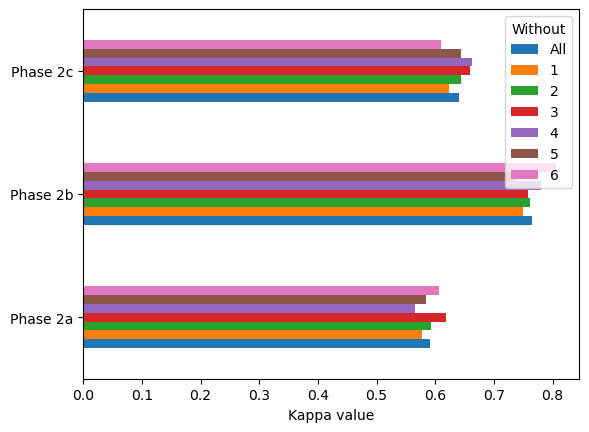

In [38]:
# Inter-rater reliability of Phases 2a to 2c for class hatespeech
res = results.T.loc[[('Phase 2a', 'HS'),('Phase 2b', 'HS'),('Phase 2c', 'HS')],:].reset_index(level=1, drop=True).plot.barh(xlabel='Kappa value').get_figure()
res.savefig("figures/mhs/interrater-reliability_hs.png")

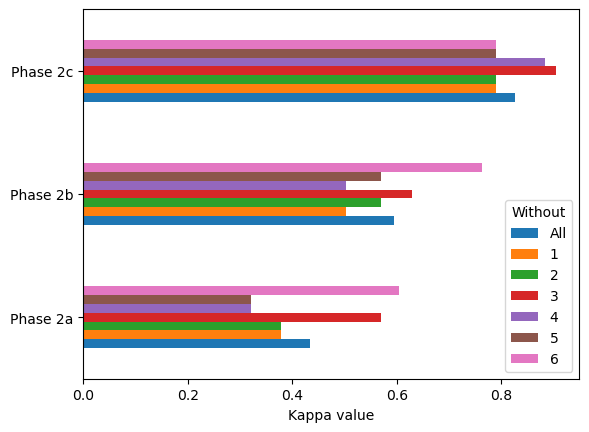

In [39]:
# Inter-rater reliability of Phases 2a to 2c for class misogynistic hatespeech
res2 = results.T.loc[[('Phase 2a', 'MHS'),('Phase 2b', 'MHS'),('Phase 2c', 'MHS')],:].reset_index(level=1, drop=True).plot.barh(xlabel='Kappa value').get_figure()
res2.savefig("figures/mhs/interrater-reliability_mhs.png")

In [40]:
# Results for inter-rater reliability for all annotators and any combination of n-1 annotators, by excluding annotator i
results

Phase 2a         Phase 2b         Phase 2c        
              HS     MHS       HS     MHS       HS     MHS
Without                                                   
All       0.5904  0.4349   0.7655  0.5939   0.6409  0.8258
1         0.5776  0.3794   0.7490  0.5034   0.6242  0.7909
2         0.5919  0.3794   0.7611  0.5700   0.6435  0.7909
3         0.6182  0.5704   0.7587  0.6286   0.6600  0.9045
4         0.5656  0.3205   0.7802  0.5034   0.6618  0.8844
5         0.5843  0.3205   0.7384  0.5700   0.6435  0.7909
6         0.6060  0.6044   0.8054  0.7637   0.6103  0.7909

In [41]:
results_latex = results.style.highlight_max(axis=0,
                           props='bfseries: ;')
results_latex.format(precision=4)
results_latex.to_latex(sparse_index=True, hrules=True, multicol_align="c", buf='tables/mhs/interrater-reliability.tex')

### Phase 3 (Productive) ###

In [42]:
annotations_ph3 = pd.read_csv('datasets/misogynistic_hatespeech_phase3.csv', sep=',')

In [43]:
print('Anzahl Annotationen:')
display(annotations_ph3.count())

Anzahl Annotationen:


tweet_id          7061
review_text       7061
hs                7061
m_hs              7061
annotation_id     7061
created_at        7061
updated_at        7061
phase             7061
lead_time         7061
annotator_name    7061
source            7061
split_hs          7061
split_m_hs        7061
dtype: int64

In [44]:
annotations_ph3.head()

,tweet_id,review_text,hs,m_hs,annotation_id,created_at,updated_at,phase,lead_time,annotator_name,source,split_hs,split_m_hs
0,1478696159766097920,"@TwitterUser hahaha, wär geil wenn das stimmt",0,0,5011,2022-03-23T16:48:23.234897Z,2022-03-23T16:48:23.234915Z,3,2.888,1,gmhp7k,train,train
1,hasoc_de_1996,"Irland 🇮🇪 Dieses verstörende Video wurde in den Dubliner Bergen während der Eid al-Adha gefilmt. Darin sehen wir eine Gruppe Muslime, die ein Lamm auf den Boden stecken und ihm die Kehle durchschneiden. Die Barbarei des Halal-Gemetzels kennt keine Grenzen.",1,0,5010,2022-03-23T16:48:18.578298Z,2022-03-23T16:48:18.578324Z,3,17.419,1,hasoc_2019,train,train
2,1481664280713907968,@TwitterUser Mareile ist ziemlich toxisch. Und heiße Luft produziert sie ebenfalls reichlich.,0,0,5009,2022-03-23T16:47:59.457107Z,2022-03-23T16:47:59.457131Z,3,9.925,1,gmhp7k,train,train
3,1473010577530408960,"ich weiß, aber du hast irgendwann gemeint du gehst da raus oder irgendsowas. hab das handy auch ""säubern"" müssen.",0,0,5008,2022-03-23T16:47:35.689926Z,2022-03-23T16:47:35.689944Z,3,6.853,1,gmhp7k,train,test
4,1440748109932350976,@TwitterUser Kritik an Antisemiten ist neuerdings rechtsextrem. Hat auch wieder keiner gewusst.,0,0,5007,2022-03-23T16:47:27.102173Z,2022-03-23T16:47:27.102189Z,3,9.775,1,gmhp7k,test,test


In [45]:
# Find entries with not numeric tweet_id
len(annotations_ph3[~annotations_ph3.tweet_id.str.isnumeric()]['tweet_id'].unique())

340

In [46]:
# Posts per annotator
annotations_ph3['annotator_name'].value_counts()

0    2428
1    2357
2    1485
3     685
4     106
Name: annotator_name, dtype: int64

In [47]:
annotations_ph3['phase'].value_counts()

3    7061
Name: phase, dtype: int64

In [48]:
print('Posts:', len(annotations_ph3['tweet_id'].unique()))

Posts: 7061


In [49]:
# Ratio of hatespeech posts
annotations_ph3['hs'].value_counts(normalize=True)

0    0.777085
1    0.222915
Name: hs, dtype: float64

In [50]:
# Ratio of misogynistic hatespeech posts
annotations_ph3.groupby('m_hs').size() / annotations_ph3.groupby('m_hs').size().sum()

m_hs
0    0.934853
1    0.065147
dtype: float64

In [51]:
phase3_distribution_hs = pd.DataFrame()
phase3_distribution_mhs = pd.DataFrame()

In [52]:
phase3_distribution_hs['Posts'] = annotations_ph3['hs'].value_counts()
phase3_distribution_hs['%'] = annotations_ph3['hs'].value_counts(normalize=True)
phase3_distribution_hs = phase3_distribution_hs.rename(index={1: 'Hatespeech'})
phase3_distribution_hs = phase3_distribution_hs.rename(index={0: 'Not hatespeech'})

In [53]:
phase3_distribution_mhs['Posts'] = annotations_ph3['m_hs'].value_counts()
phase3_distribution_mhs['%'] = annotations_ph3['m_hs'].value_counts(normalize=True)
phase3_distribution_mhs = phase3_distribution_mhs.rename(index={1: 'Misogynistic hatespeech'})
phase3_distribution_mhs = phase3_distribution_mhs.rename(index={0: 'Not misogynistic hatespeech'})

In [54]:
phase3_distribution = pd.concat([phase3_distribution_hs, phase3_distribution_mhs], axis=0)

In [55]:
phase3_distribution['%'] = phase3_distribution['%'] * 100
phase3_distribution['%'] = phase3_distribution['%'].round(2)

In [56]:
# Class distribution of posts in phase 3
phase3_distribution

,Posts,%
Not hatespeech,5487,77.71
Hatespeech,1574,22.29
Not misogynistic hatespeech,6601,93.49
Misogynistic hatespeech,460,6.51


In [57]:
phase3_distribution_latex = phase3_distribution.style.format(subset="%", precision=2).format(subset="Posts", precision=0, thousands=",").format_index(escape="latex", axis=1).format_index(escape="latex", axis=0)
#phase3_distribution_latex.format(precision=4)
phase3_distribution_latex.to_latex(sparse_index=True, hrules=True, multicol_align="c", buf='tables/mhs/phase3_distribution.tex')

In [58]:
 # Parameters for text processing
f_stopwords= 'stop_words_german.txt'
transformer_model=False

In [59]:
df = annotations_ph3[['tweet_id', 'review_text', 'hs', 'm_hs']].copy()

In [60]:
### Text preprocessing:
nlp = spacy.load('de_core_news_sm')

#Create Stopword list from local file:
stop_words= pd.read_csv(f_stopwords, header=None)
german_stop_words=list(stop_words[0])


#Key Words from Dataset Creation:
keywords= ['dorfmatratze' , 'flittchen' , 'fotze' , 'hürchen' , 'hure' , 'schlampe' , 'bitch' , 'cunt' , 'hoe' , 'pussy' , 'slut' , 'whore']


def preprocess_text(text: str, transformer_ds: bool) -> str:
    # This  function sanitizes a string by:
    # - removing special characters
    # - removing numbers
    # - removing stopwords
    # - transforming in lowercase
    # - removing excessive whitespaces

    # remove special chars and numbers
    text = re.sub("[^A-Za-zäÄöÖüÜß]+", " ", text)
    # 6. Remove twitteruser mentioning
    text = re.sub("(TwitterUser)", " ", text)
    # remove stopwords
    if not transformer_ds:
        # 1. Apply german lemmatizer from SPACY:
        # text = " ".join(tokens)
        text= " ".join([w.lemma_ for w in nlp(text)])
        # 2. tokenize
        tokens = nltk.word_tokenize(text,language='german')
        # 3. check if stopword
        tokens = [w for w in tokens if not w.lower() in german_stop_words]
        # 4. Remove words with letters < 3
        regex = re.compile(r'\b\w{1,2}\b')
        tokens = [w for w in tokens if not regex.search(w.lower())]
        # 5. Remove keywords which were used during dataset creation
        tokens = [w for w in tokens if not w.lower() in keywords]
        # 6. Remove twitteruser mentioning
        text = " ".join(tokens)
        text = re.sub("(TwitterUser)", " ", text)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

df.loc[:,'cleaned_corpus'] = df.loc[:,'review_text'].apply(lambda x: preprocess_text(x, transformer_ds=transformer_model))

## Test preprocess method
# preprocess_text('ich hole meine Freundin ab am frühen Morgen mit Experten',False)

In [61]:
# create tokenized text
# Each sentence must be a list of string tokens
df.loc[:, 'tokenized_text'] = df.loc[:, 'cleaned_corpus'].apply(lambda x: word_tokenize(x,language='german'))

In [62]:
#npmi = 1 --> Word only appear together
#npmi = 0--> Normal Distribution
#npmi =-1--> Words never in the same document


def count_cooccurence_word_label(vectorizer,sentences):
    X = vectorizer.fit_transform(sentences)
    sum_words= X.sum(axis=0)
    word_freq_list = {}
    for word,index in vectorizer.vocabulary_.items():
        word_freq_list[word]=sum_words[0,index]
    return word_freq_list

### Test
#count_cooccurence_word_label(vectorizer,df[df['class']==2]['cleaned_corpus'])



def calc_npmi(label_df,df,min_count=2,threshhold=0.5):
    #label_phrase_model = Phrases(label_df, min_count=min_count, threshold=threshhold,scoring='npmi')
    # initialize the vectorizer
    vectorizer = CountVectorizer(ngram_range=(1,1),min_df=min_count)
    label_word_count=count_cooccurence_word_label(vectorizer,label_df)
    phrase_model = Phrases(df['tokenized_text'], min_count=min_count, threshold=threshhold,scoring='npmi')
    N = phrase_model.corpus_word_count
    x = len(label_df)
    score_word_dict={}
    for key in label_word_count:
        x_y= label_word_count[key]
        y= phrase_model.vocab[key]
        score= npmi_scorer(worda_count=x,wordb_count=y,bigram_count=x_y,
                    corpus_word_count=N,
                    len_vocab=None,
                    min_count=min_count
                    )
        score_word_dict[key]=score
    return pd.DataFrame(score_word_dict,index=range(len(score_word_dict))).T[0]

hs_npmi = calc_npmi(df[(df['hs'] == 1) & (df['m_hs'] == 0)]['cleaned_corpus'], df).sort_values(ascending=False)
f_hs_npmi = calc_npmi(df[df['m_hs'] == 1]['cleaned_corpus'], df).sort_values(ascending=False)
neutral_npmi = calc_npmi(df[df['hs'] == 0]['cleaned_corpus'], df)

In [63]:
# Top 20 words by npmi score for each class
print(f'Top 20 Neutral:\n{neutral_npmi.sort_values(ascending=False)[:20]}')
print(f'Top 20 hs:\n{hs_npmi[:20]}')
print(f'Top 20 f_hs:\n{f_hs_npmi[:20]}')

Top 20 Neutral:
geben           0.286858
sehen           0.273666
grün            0.272980
danke           0.262476
finden          0.261737
sagen           0.261464
regierung       0.258984
eigentlich      0.254601
neu             0.254220
einfach         0.252287
denken          0.252021
kind            0.249372
genau           0.248704
leben           0.248483
halten          0.248107
halt            0.245521
wählen          0.245467
entscheidung    0.244531
welt            0.243733
sicher          0.242340
Name: 0, dtype: float64
Top 20 hs:
hurensohn        0.453359
pack             0.431970
baerziege        0.420717
gesindel         0.419729
abschaum         0.415533
verrecken        0.414354
verrotten        0.413873
fortpflanzen     0.413813
land             0.413603
moslem           0.409567
kurde            0.408506
verbrecher       0.407994
sohn             0.389964
türke            0.387427
fresse           0.387188
musel            0.386726
vergewaltigen    0.386726
neger  

In [64]:
# Set min font size to 50
min_font_size=50

In [65]:
def generate_wordcloud(data, title=None, filename=None):
    # Generate the word cloud from frequencies
    wc = WordCloud(background_color="white", min_font_size=min_font_size, relative_scaling=0,
                   width=3000,
                   height=1500).generate_from_frequencies(data)

    plt.figure()
    plt.imshow(wc)
    plt.title(title)
    plt.axis('off')
    if filename:
        #plt.savefig(filename)
        wc.to_file(filename)
    plt.show()

In [66]:
# Multiply scores by 100
neutral_npmi_norm = neutral_npmi * 100
hs_npmi_norm = hs_npmi * 100
f_hs_npmi_norm = f_hs_npmi * 100

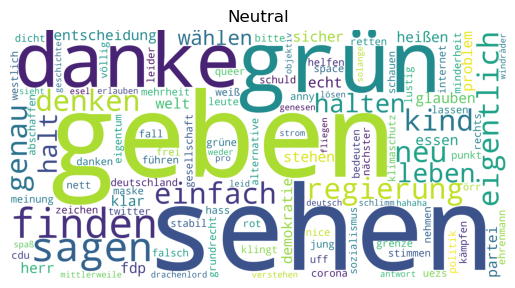

In [67]:
# Word cloud for class neutral
generate_wordcloud(neutral_npmi_norm.sort_values(ascending=False), 'Neutral', f'figures/mhs/wordcloud_neutral_{min_font_size}.png')

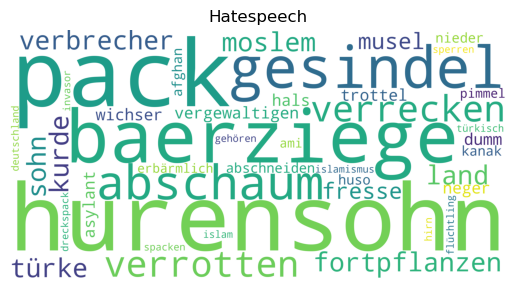

In [68]:
# Word cloud for class hatespeech
generate_wordcloud(hs_npmi_norm, 'Hatespeech', f'figures/mhs/wordcloud_hatespeech_{min_font_size}.png')

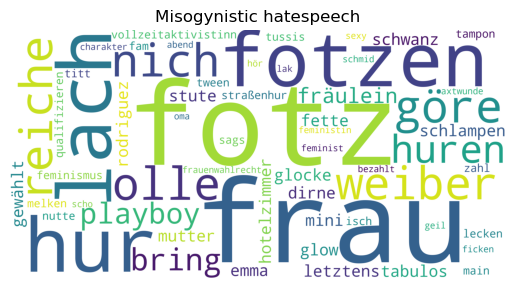

In [69]:
# Word cloud for class misogynistic hatespeech
generate_wordcloud(f_hs_npmi_norm, 'Misogynistic hatespeech', f'figures/mhs/wordcloud_misogynistic_hatespeech_{min_font_size}.png')

# Split of hatespeech data into train-, validation- and testset

In [70]:
# Class distribution
annotations_ph3.groupby(['split_hs'])['hs'].value_counts()

split_hs  hs
test      0      549
          1      158
train     0     4389
          1     1259
val       0      549
          1      157
Name: hs, dtype: int64

In [71]:
# Class distribution
annotations_ph3.groupby(['split_hs'])['hs'].value_counts(normalize=True)

split_hs  hs
test      0     0.776521
          1     0.223479
train     0     0.777089
          1     0.222911
val       0     0.777620
          1     0.222380
Name: hs, dtype: float64

# Split of misogynistic hatespeech data into train-, validation- and testset

In [72]:
# Class distribution
annotations_ph3.groupby(['split_m_hs'])['m_hs'].value_counts()

split_m_hs  m_hs
test        0        661
            1         46
train       0       5280
            1        368
val         0        660
            1         46
Name: m_hs, dtype: int64

In [73]:
# Class distribution
annotations_ph3.groupby(['split_m_hs'])['m_hs'].value_counts(normalize=True)

split_m_hs  m_hs
test        0       0.934936
            1       0.065064
train       0       0.934844
            1       0.065156
val         0       0.934844
            1       0.065156
Name: m_hs, dtype: float64